<a href="https://colab.research.google.com/github/MichelleAppel/distribution-aware-image-to-image-translation/blob/master/toy_examples/Fly_data_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import os.path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms

from itertools import chain

import numpy as np
import math
import itertools
import random

from scipy import signal

import matplotlib.pyplot as plt

import zipfile

# Fly data experiment

Todo:
*   Use annotations somehow
*   Improve networks: AE and weightnet are not tailored for 128x128 images

## The Networks

In [38]:
zipdataroot_A = '/content/drive/MyDrive/fly_data_ubc_2021/generated_fly_with_annotation.zip'
zipdataroot_B = '/content/drive/MyDrive/fly_data_ubc_2021/real_fly.zip'

dataroot_A = '/content/flydata/data_A'
dataroot_B = '/content/flydata/data_B'

if not os.path.exists(dataroot_A):
  with zipfile.ZipFile(zipdataroot_A, 'r') as zip_ref:
      zip_ref.extractall(dataroot_A)

if not os.path.exists(dataroot_B):
  with zipfile.ZipFile(zipdataroot_B, 'r') as zip_ref:
      zip_ref.extractall(dataroot_B)

In [39]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname) and not fname.endswith('real_A.png') and not fname.endswith('render_pose.png'):
                path = os.path.join(root, fname)
                images.append(path)

    return images

In [101]:
def __adjust(img):
    ow, oh = img.size

    # the size needs to be a multiple of this number,
    # because going through generator network may change img size
    # and eventually cause size mismatch error
    mult = 4
    if ow % mult == 0 and oh % mult == 0:
        return img
    w = (ow - 1) // mult
    w = (w + 1) * mult
    h = (oh - 1) // mult
    h = (h + 1) * mult

    return img.resize((w, h), Image.BICUBIC)

def get_transform():
    loadSize = 128
    osize = [loadSize, loadSize]

    transform_list = []
    transform_list.append(transforms.Lambda(
            lambda img: __adjust(img)))
    
    transform_list.append(transforms.Resize(osize, Image.BICUBIC))  
    transform_list += [transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

In [102]:
class FlyDataset(Dataset):
  def __init__(self):
    self.dataroot_A = dataroot_A
    self.dataroot_B = dataroot_B

    self.A_paths = make_dataset(self.dataroot_A)
    self.B_paths = make_dataset(self.dataroot_B)

    self.A_size = len(self.A_paths)
    self.B_size = len(self.B_paths)

    self.dir_len = len(self.dataroot_A) + 1

    self.transform = get_transform()

  def __getitem__(self, index):
      A_path = self.A_paths[index % self.A_size]
      A_name = A_path[self.dir_len:]
      
      index_B = random.randint(0, self.B_size - 1)
          
      B_path = self.B_paths[index_B]

      A_img = Image.open(A_path).convert('RGB')
      B_img = Image.open(B_path).convert('RGB')

      A = self.transform(A_img)
      B = self.transform(B_img)

      return {'A': A, 'B': B}

  def __len__(self):
    return max(self.A_size, self.B_size)

In [103]:
dataset = FlyDataset()

batch_size = 32
dataloader = DataLoader(dataset, batch_size, shuffle=True)

## The Networks

TODO: improve networks

In [251]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.softmax = nn.Softmax(dim=0)

        self.conv1 = nn.Conv2d(3, 10, kernel_size=7)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5)
        self.fc1 = nn.Linear(40*12*12, 40)
        self.fc2 = nn.Linear(40, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        h2 = torch.sigmoid(F.max_pool2d(self.conv2(h1), 2))
        h3 = torch.sigmoid(F.max_pool2d(self.conv3(h2), 2))
        h4 = h3.view(-1, 40*12*12)
        h5 = torch.sigmoid(self.fc1(h4))
        out = self.fc2(h5)
        return self.softmax(out), out

In [263]:
class AE(nn.Module):
    # from https://www.kaggle.com/ljlbarbosa/convolution-autoencoder-pytorch
    def __init__(self):
        super(AE, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 7, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 5, padding=1)

        self.conv3 = nn.Conv2d(4, 1, 5, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(1, 4, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(4, 16, 5, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 3, 8, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = torch.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.relu(self.conv3(x))
        latent_space = self.pool(x)  # compressed representation

        ## decode ##
        # add transpose conv layers, with relu activation function
        x = torch.relu(self.t_conv1(latent_space))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.relu(self.t_conv2(x))
        x = torch.sigmoid(self.t_conv3(x))
                
        return x, latent_space

In [264]:
def n_centered_moment(x, w, n):
  if n > 1:
    c = n_centered_moment(x, w, 1)
  else:
    c = 0
  return (((x - c)**n)*w).sum(0)

In [265]:
def visualize(img):
  plt.imshow(-img.permute(1,2,0))
  plt.show()

In [266]:
# for epoch in range(1):
#     for i, data in enumerate(dataloader):
#       visualize(data['A'][0])
#       visualize(data['B'][0])
#       break

## Training

In [267]:
# Initialize the networks
weight_network = WeightNet().cuda()
autoencoder = AE().cuda()

# Initialize the optimizers
lr = 0.01
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=lr)

criterion_w = nn.MSELoss()
criterion_ae = nn.BCELoss()

# For storing results
losses_w = []
losses_ae = []

means_A = []
means_B = []

vars_A = []
vars_B = []

moments_A = []
moments_B = []

example_importances_A = []

n = 1 # n-centered moment

for epoch in range(5):
    for i, data in enumerate(dataloader):
        
        img_A = data['A'].cuda()
        img_B = data['B'].cuda()

        label_A = None
        label_B = None

        batch_size = img_A.shape[0]

        # The embeddings
        reconstructed_A, e_A = autoencoder(img_A)
        reconstructed_B, e_B = autoencoder(img_B)

        # The weighting process
        w_A = weight_network(img_A)[0]
        w_B = 1/len(img_B)

        # The loss function --------------------------------------------------------------------------------
        n_centered_moment_A = n_centered_moment(e_A.view(batch_size, -1).detach(), w_A, n)
        n_centered_moment_B = n_centered_moment(e_B.view(batch_size, -1).detach(), w_B, n)
        loss_w = criterion_w(n_centered_moment_A, n_centered_moment_B)

        loss_ae_A = criterion_ae(reconstructed_A, img_A)
        loss_ae_B = criterion_ae(reconstructed_B, img_B)
        loss_ae = loss_ae_A + loss_ae_B
        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step() 

        optimizer_ae.zero_grad()
        loss_ae.backward()
        optimizer_ae.step()     

        # Store values --------------------------------------------------------------------------------------
        moments_A += [n_centered_moment_A.cpu().detach().numpy()]
        moments_B += [n_centered_moment_B.cpu().detach().numpy()]

        means_A += [n_centered_moment(e_A.view(batch_size, -1), w_A, 1).detach().cpu().numpy()]
        means_B += [n_centered_moment(e_B.view(batch_size, -1), w_B, 1).detach().cpu().numpy()]

        vars_A += [n_centered_moment(e_A.view(batch_size, -1), w_A, 2).detach().cpu().numpy()]
        vars_B += [n_centered_moment(e_B.view(batch_size, -1), w_B, 2).detach().cpu().numpy()]    

        losses_w += [loss_w.item()]
        losses_ae += [loss_ae.item()]

        # w_a = weight_network(dataset_A.example_imgs.cuda().unsqueeze(1).float())
        # example_importances_A += [[importance.item() for importance in w_a[0]]] # Store examples in a list

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 10 == 0:
            print('epoch', epoch, 'step', i, 'loss_w: ', loss_w.item(), 'loss_ae', loss_ae.item())
            
        if i % 10000 == 0 and i != 0:
            break

epoch 0 step 0 loss_w:  9.357011003885418e-05 loss_ae 1.305098056793213
epoch 0 step 10 loss_w:  810.3526000976562 loss_ae -125.83407592773438
epoch 0 step 20 loss_w:  6217.99755859375 loss_ae -126.43059539794922
epoch 0 step 30 loss_w:  9550.2734375 loss_ae -126.07467651367188
epoch 0 step 40 loss_w:  13720.3310546875 loss_ae -126.00808715820312
epoch 1 step 0 loss_w:  15981.435546875 loss_ae -126.51284790039062
epoch 1 step 10 loss_w:  12603.224609375 loss_ae -126.10542297363281
epoch 1 step 20 loss_w:  13215.40234375 loss_ae -125.96786499023438
epoch 1 step 30 loss_w:  14418.6806640625 loss_ae -125.99417114257812
epoch 1 step 40 loss_w:  14291.6875 loss_ae -126.00379943847656
epoch 2 step 0 loss_w:  13005.849609375 loss_ae -126.21553802490234
epoch 2 step 10 loss_w:  14339.0146484375 loss_ae -126.27584075927734
epoch 2 step 20 loss_w:  12630.818359375 loss_ae -126.09376525878906
epoch 2 step 30 loss_w:  16759.71484375 loss_ae -125.81700134277344
epoch 2 step 40 loss_w:  16321.384765

In [269]:
moments_A = torch.Tensor(moments_A)
moments_B = torch.Tensor(moments_B)
means_A = torch.Tensor(means_A)
means_B = torch.Tensor(means_B)
vars_A = torch.Tensor(vars_A)
vars_B = torch.Tensor(vars_B)

## Results

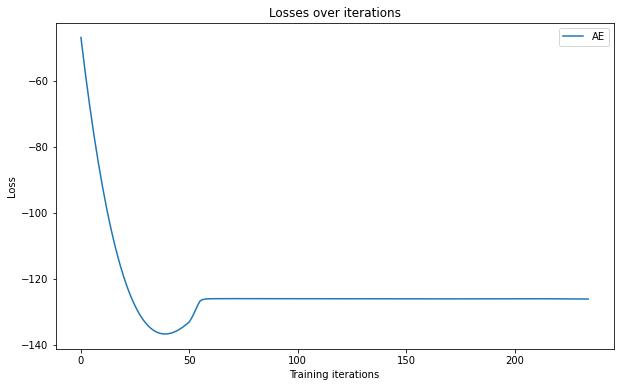

In [270]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
smoothed_losses_ae = signal.savgol_filter(losses_ae,101,3)
plt.plot(smoothed_losses_ae)
plt.legend(['AE'])
plt.show()

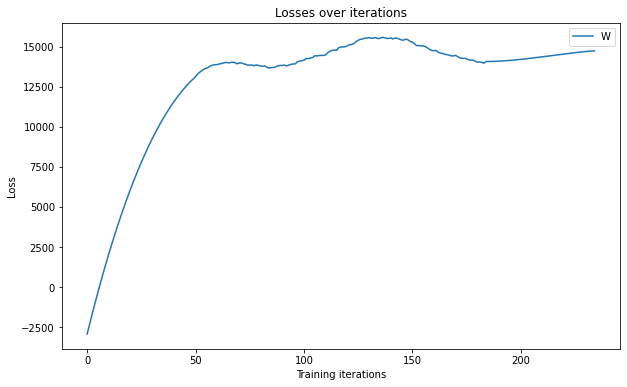

In [271]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
smoothed_losses_w = signal.savgol_filter(losses_w,101,3)
plt.plot(smoothed_losses_w)
plt.legend(['W'])
plt.show()

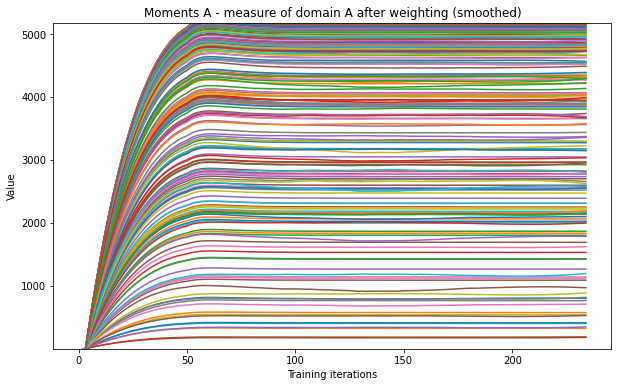

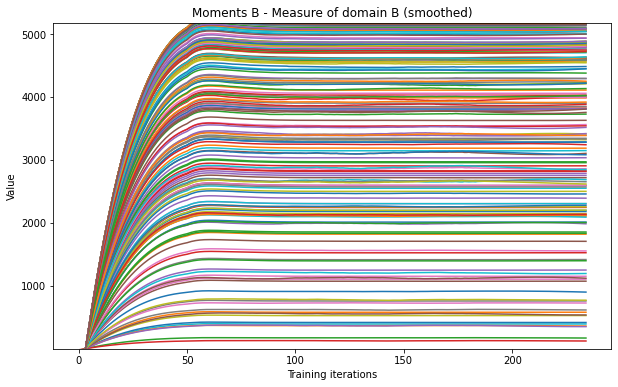

In [272]:
plt.figure(figsize=(10,6))
plt.title('Moments A - measure of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lmin = signal.savgol_filter(moments_A,101,3,axis=0)
plt.plot(smoothed_Lmin)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Moments B - Measure of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lplus = signal.savgol_filter(moments_B,101,3,axis=0)
plt.plot(smoothed_Lplus)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image with weight 0.5499542355537415


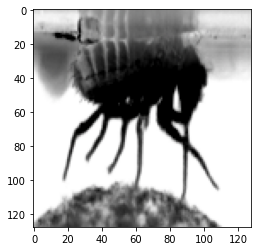

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image with weight 0.685133159160614


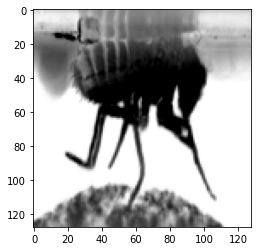

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image with weight 0.5532183051109314


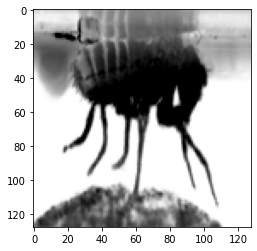

In [283]:
# These are generated images
weights = weight_network(img_A)[0]
weights *= len(weights)

for image, weight in zip(img_A[:3], weights):
  print('Image with weight', weight.item())
  visualize(image.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image with weight 0.3405757546424866


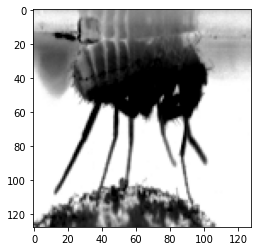

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image with weight 1.8028380870819092


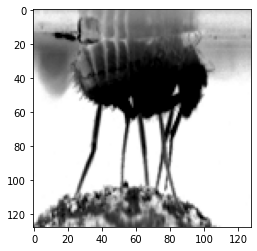

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image with weight 1.7768566608428955


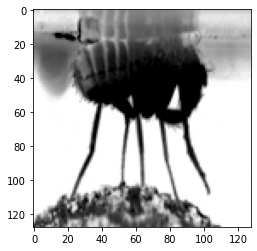

In [276]:
# These are real images
weights = weight_network(img_B)[0]
weights *= len(weights)

for image, weight in zip(img_B[:3], weights):
  print('Image with weight', weight.item())
  visualize(image.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


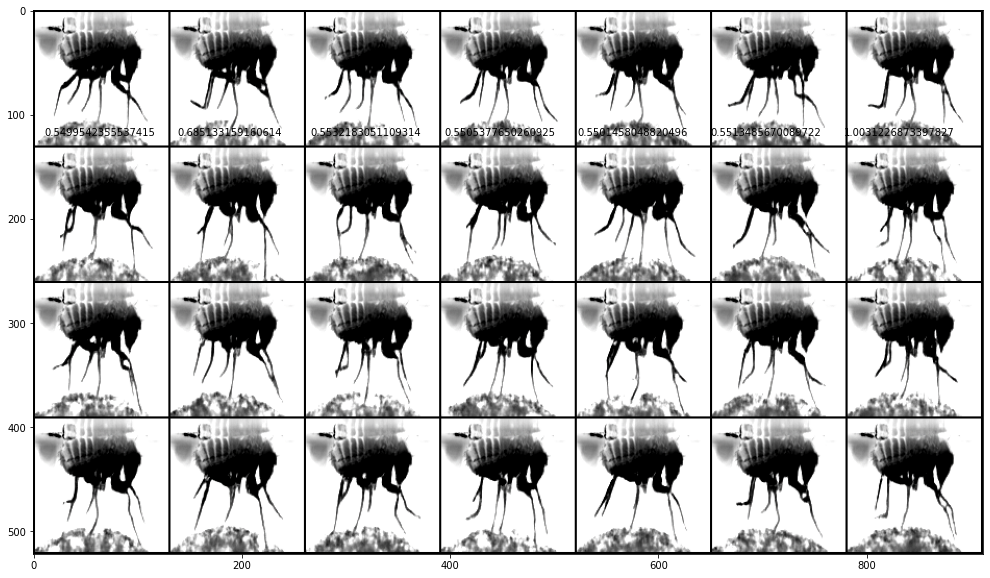

In [327]:
# Work in progress

grid = make_grid(img_A.cpu(), nrow=7).permute(1,2,0)

plt.figure(figsize=(20,10))
plt.imshow(grid/grid.mean())

width = 128*7
height = 128*4
for i, w in enumerate(weights[:7]):
  plt.text(10+i*128,120,w.item())
plt.show()